In [1]:
import stl
from stl import mesh
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal 
from scipy.signal import fftconvolve
import soundfile as sf
from mpl_toolkits import mplot3d

import pyroomacoustics as pra

In [2]:
%matplotlib notebook

In [3]:
path_to_musis_stl_file = "data/smaller_slicedup_OC_evenmore.stl"

#path_to_musis_stl_file = './INRIA_MUSIS.stl'


material = pra.Material(energy_absorption=0.4, scattering=0.5)

# with numpy-stl
the_mesh = mesh.Mesh.from_file(path_to_musis_stl_file)
ntriang, nvec, npts = the_mesh.vectors.shape
size_reduc_factor = 1  # to get a realistic room size (not 3km)

In [4]:
# create one wall per triangle
walls = []
for w in range(ntriang):
    walls.append(
        pra.wall_factory(
            the_mesh.vectors[w].T / size_reduc_factor,
            material.energy_absorption["coeffs"],
            material.scattering["coeffs"],
        )
    )

In [5]:
source_sound = np.random.normal(0,1,1000)
source_sound *= signal.hanning(source_sound.size)

source_position = np.array([-0.2, 0, -1])
central_mic_pos = np.array([-0.75, 01.66, -0.5])

source_position = source_position.tolist()
central_mic_pos = central_mic_pos.tolist()

C:\Users\theja\AppData\Local\Temp/ipykernel_1324/708954654.py:2: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  source_sound *= signal.hanning(source_sound.size)


In [6]:
call_durn = 0.004 # seconds
fs = 192000
t = np.linspace(0,call_durn,int(fs*call_durn))
bat_call = signal.chirp(t,90000, t[-1],30000)
bat_call *= signal.windows.tukey(bat_call.size, 0.95)

In [7]:
room = pra.Room(walls, fs=fs, max_order=2, ray_tracing=True, air_absorption=True).add_source(
                                    [0.05, 0.50, 0.05], signal=bat_call).add_microphone_array(
                                    np.c_[[-1.1, 0.9, 0.1], [-1.1, 0.9,0.3]])

In [8]:
room.rt_args

{'energy_thres': 1e-07,
 'time_thres': 10.0,
 'receiver_radius': 0.5,
 'hist_bin_size': 0.004,
 'hist_bin_size_samples': 768,
 'n_rays': 8004}

<IPython.core.display.Javascript object>


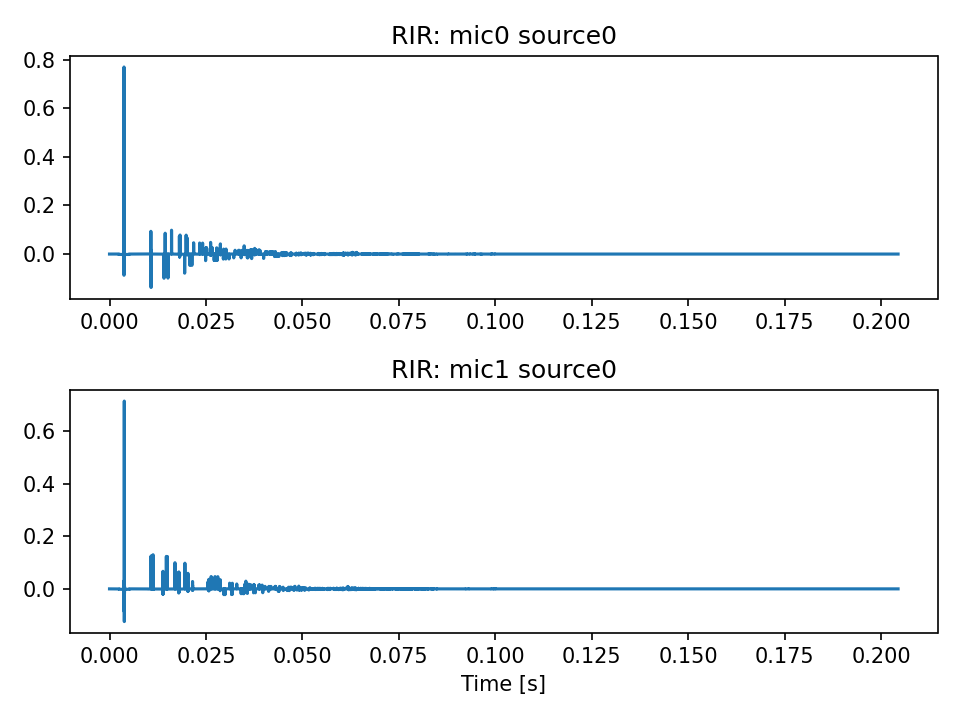

In [9]:
room.image_source_model()
room.ray_tracing()
room.compute_rir()
room.plot_rir()


<IPython.core.display.Javascript object>


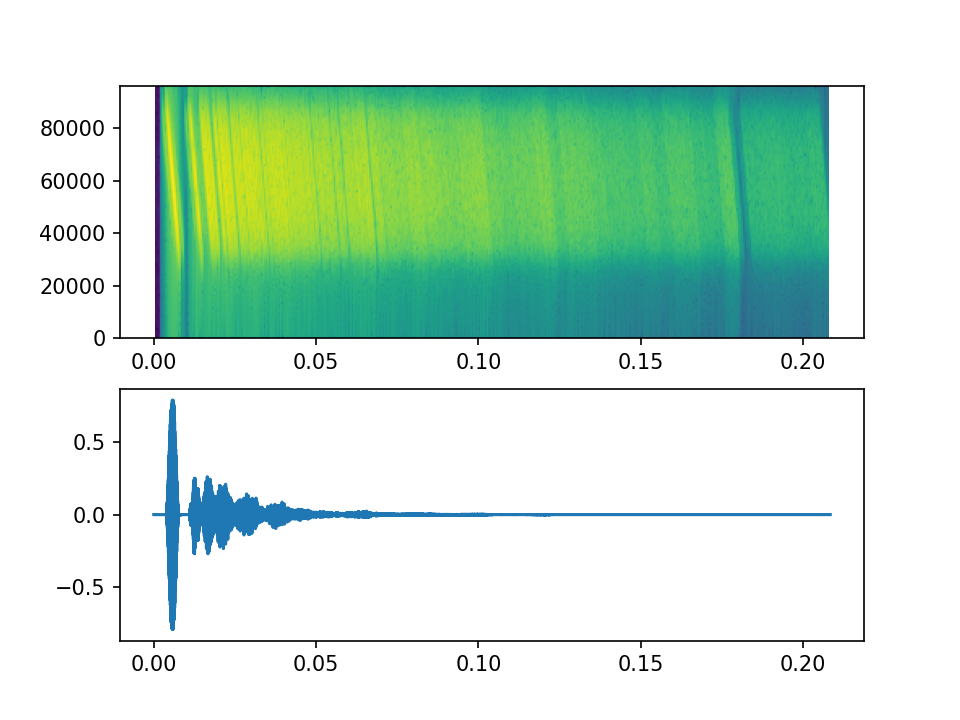

In [10]:
mic0_signal = fftconvolve(room.rir[0][0], bat_call)
mic1_signal = fftconvolve(room.rir[1][0], bat_call)
plt.figure()
a0 = plt.subplot(211)
plt.specgram(mic0_signal, Fs=fs, NFFT=192, noverlap=96);
plt.subplot(212, sharex=a0)
plt.plot(np.linspace(0,mic0_signal.size/fs,mic0_signal.size), mic0_signal)


In [11]:
stereo = np.zeros((np.max([mic0_signal.size, mic1_signal.size]),2))
stereo[:mic0_signal.size,0] = mic0_signal
stereo[:mic1_signal.size,1] = mic1_signal

In [12]:
sf.write('mic01_signal.wav', stereo, fs)
